## 1° Teste

Desta vez tentaremos um processo mais refinado:
 - Aplicar thresholding na imagem
 - Calcular a distância dos pontos selecionados no thresholding para o background
 - Coletar os pontos de máximo e mínimo globais dessas distâncias (obviamente o mínimo é sempre 0)
 - Utilizar os ponstos coletados acima como marcadores para o watershed
 - Aplicar o watershed no negativo das distâncias, usando os marcadores definidos
 - Usar funções morfológicas para retirar pequenos objetos e fechar pequenos buracos

In [2]:
# Importando pacotes

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.morphology import remove_small_holes, remove_small_objects
import nibabel as nib
import pandas as pd

In [3]:
# Definindo funções e variáveis para carregar imagens
dir_name = "../data/raw/"
img_data = pd.read_csv("../data/description.csv", dtype=str)

def getFilenameFromID(df, Id):
    file_name = "CC"
    for h in df.columns:
        file_name+=df[h][Id]+'_'
    file_name= file_name[:-1]+".nii"
    return file_name

def loadRandomImage():
    # Carrega imagem como um ndarray
    random_id = np.random.randint(0,high=358)
    file_name = getFilenameFromID(img_data, random_id)
    f = nib.load(dir_name+file_name).get_fdata()
    
    # Retira a fatia sagital central da imagem e
    # a rotaciona para uma posição mais natural 
    # e a coloca no intervalo de 0 a 255
    x = int(f.shape[0]/2)
    img = ndi.rotate(f[x,:,:], 90)
    img = 255*img/np.max(img)
    img = img.astype(np.uint8)
    
    return img, file_name

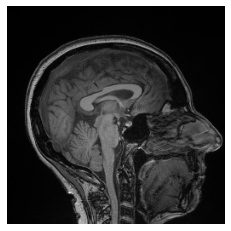

CC0237_siemens_3_59_F.nii (256, 256)


In [4]:
# Carregando uma imagem aleatória

img, file_name = loadRandomImage()
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.show()
print(file_name, img.shape)

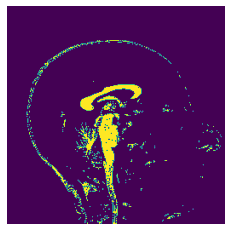

In [5]:
# O thresholding é feito manualmente, pretendo automatizar este passo em seguida.

threshold_img = np.ones(img.shape, np.int8)
threshold_img[img<110]=0
threshold_img[img>140]=0
plt.imshow(threshold_img)
plt.axis("off")
plt.show()

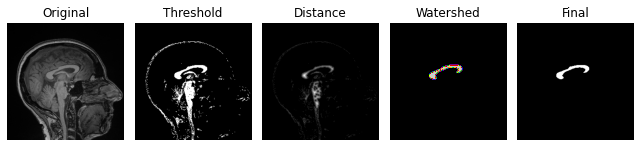

In [7]:
# Calculando a distância até o background
distance = ndi.distance_transform_edt(threshold_img)

# Criando os marcadores
markers = np.zeros(distance.shape, dtype=bool) 
mx, mn = np.max(distance), np.min(distance)
markers = (distance==mx)*2+(distance==mn)*1

# Aplicando o watershed
labels = watershed(-distance, markers)

# Removendo objetos pequenos e buracos
f0 = remove_small_holes(labels-1, 64)
final = remove_small_objects(f0, min_size=300)

# Plot
fig, axes = plt.subplots(ncols=5, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(threshold_img, cmap=plt.cm.gray)
ax[1].set_title('Threshold')
ax[2].imshow(distance, cmap=plt.cm.gray)
ax[2].set_title('Distance')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Watershed')
ax[4].imshow(final, cmap=plt.cm.gray)
ax[4].set_title('Final')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()